## LP Paw plotting for visual inspection

In [1]:
prefix = '/home/ines/repositories/'
prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [3]:
"""
Check sessions available with dlc data
@author: Ines
"""
import pandas as pd
import pickle 
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from one.api import ONE
from uuid import UUID
import json
from scipy.stats import zscore

# Get my functions
functions_path =  prefix + '/representation_learning_variability/Functions/'
os.chdir(functions_path)
from video_functions import keypoint_speed_one_camera
from one_functions_generic import timeseries_PSTH

one = ONE(mode='remote')

### Get extended QC of all sessions

In [4]:
ext_qc_path = prefix + '/representation_learning_variability/Video and wheel/Video QC/'
os.chdir(ext_qc_path)
ext_qc = pickle.load(open(ext_qc_path + "extended_qc07-08-2025", "rb"))
use_qc = ext_qc.loc[ext_qc['task'].isin(['PASS', 'WARNING'])]
final_qc = use_qc.loc[(use_qc['_lightningPoseLeft_lick_detection'].isin(['PASS'])) &
                             (use_qc['_lightningPoseLeft_time_trace_length_match'].isin(['PASS'])) &   
                             (use_qc['_videoLeft_pin_state'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &
                             (use_qc['_lightningPoseLeft_trace_all_nan'].isin(['PASS'])) &
                             (use_qc['_videoLeft_framerate'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &   
                             (use_qc['_videoLeft_camera_times'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &   
                             (use_qc['_videoLeft_dropped_frames'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &  # can make more conservative by removing or  x == None
                             (use_qc['_videoLeft_timestamps'].isin([True, 'PASS']))                   
                            ]

/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/one_functions_generic.py:554: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  trials['prev_choice'][1:] = trials['choice'][:-1]
/Users/ineslaranjeira/Do

KeyboardInterrupt: 

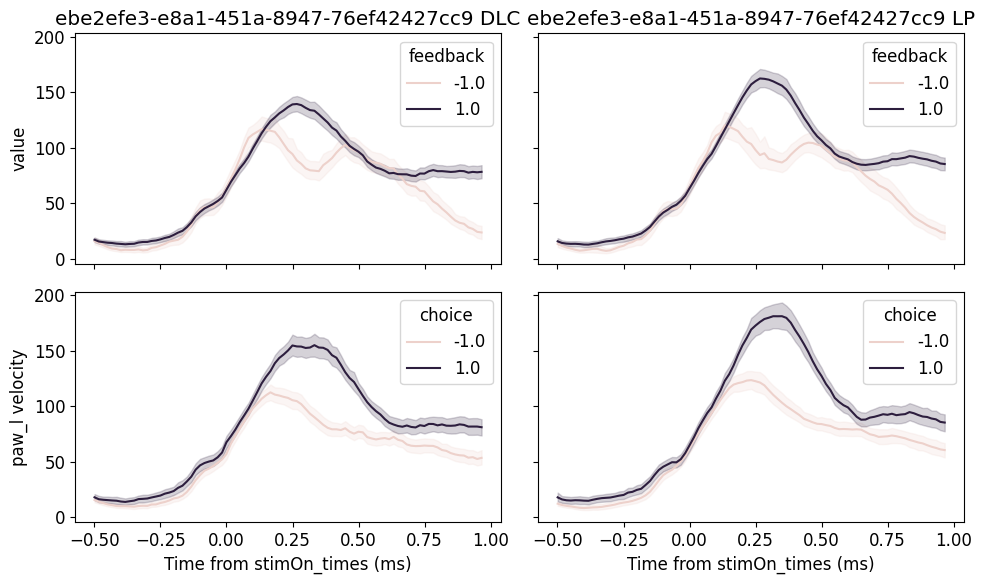

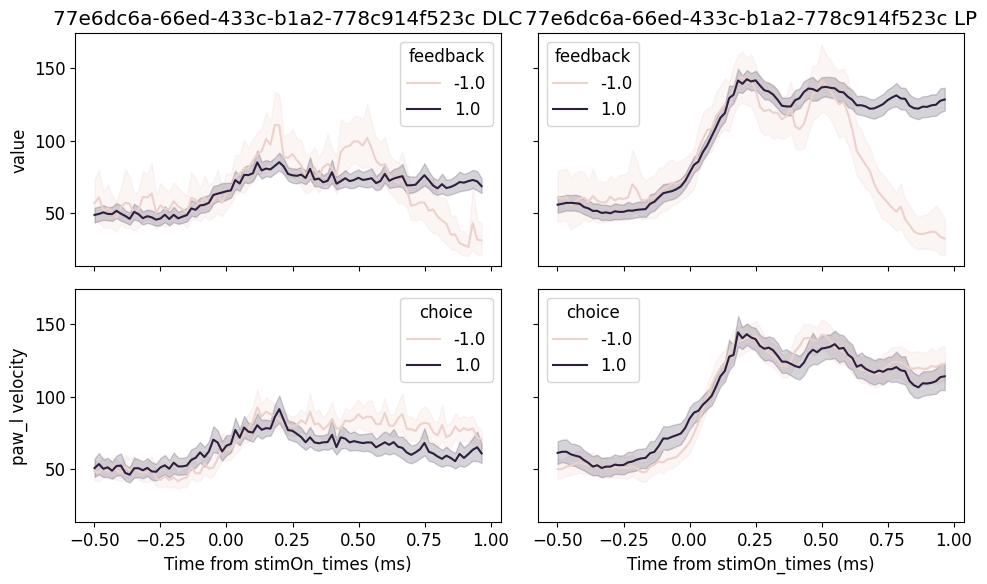

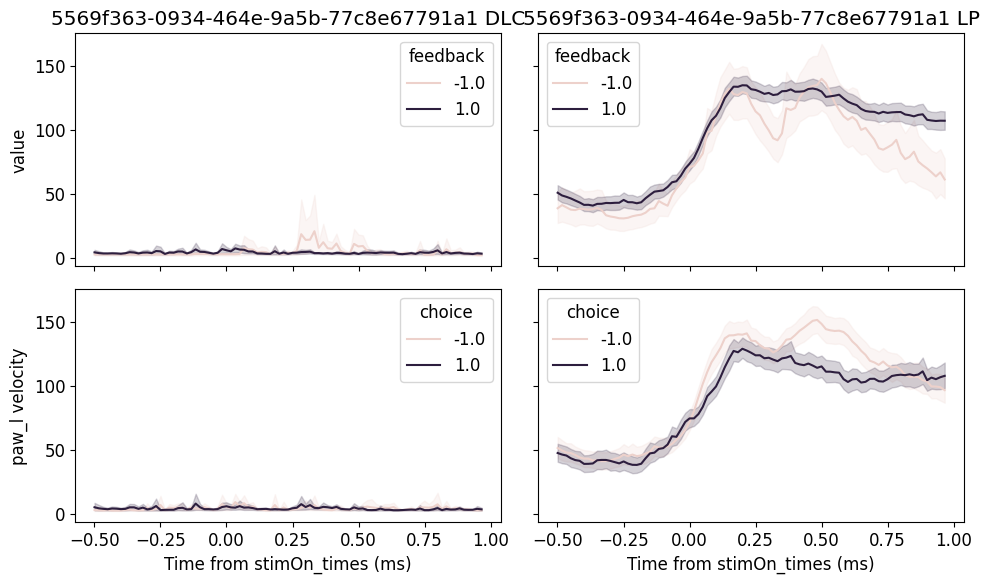

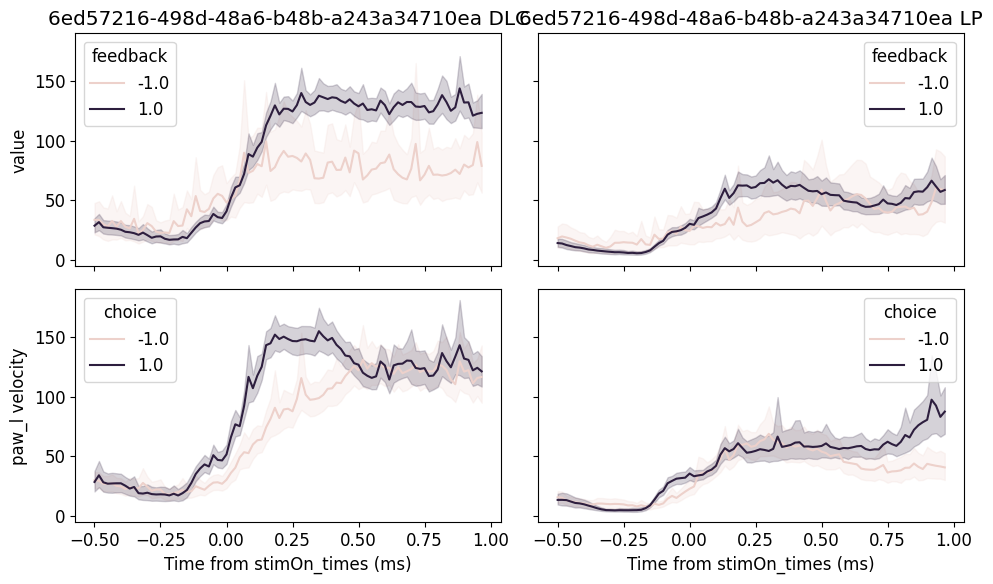

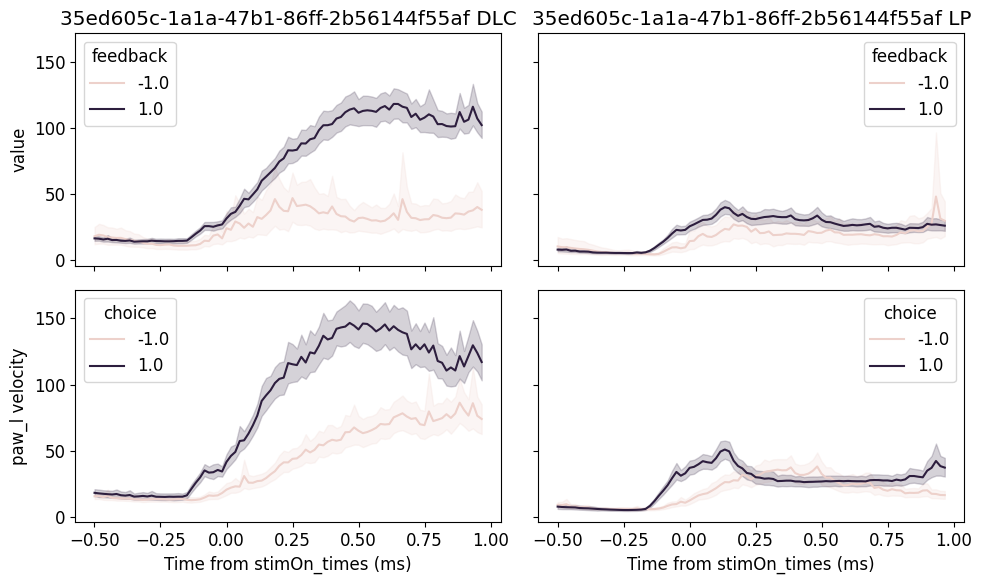

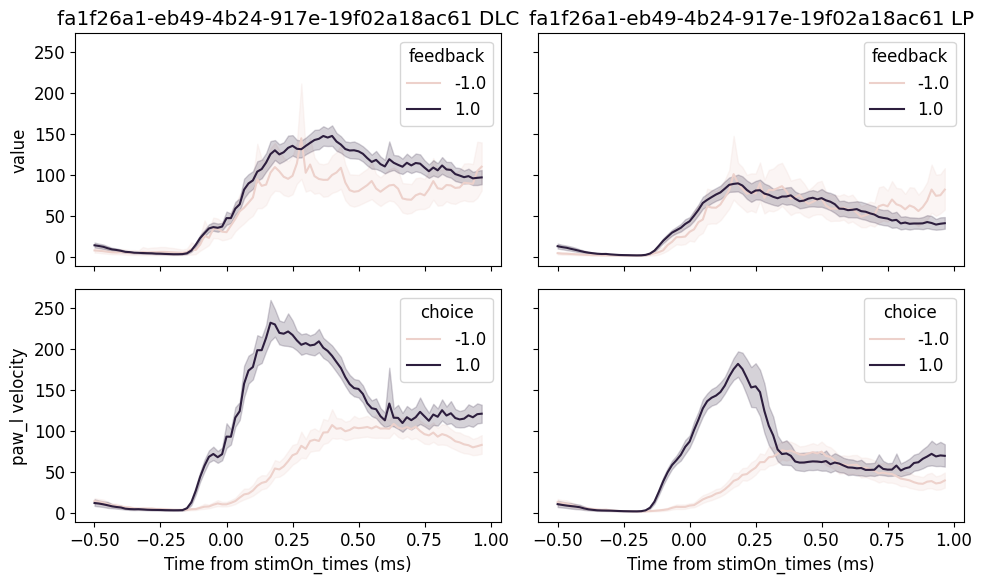

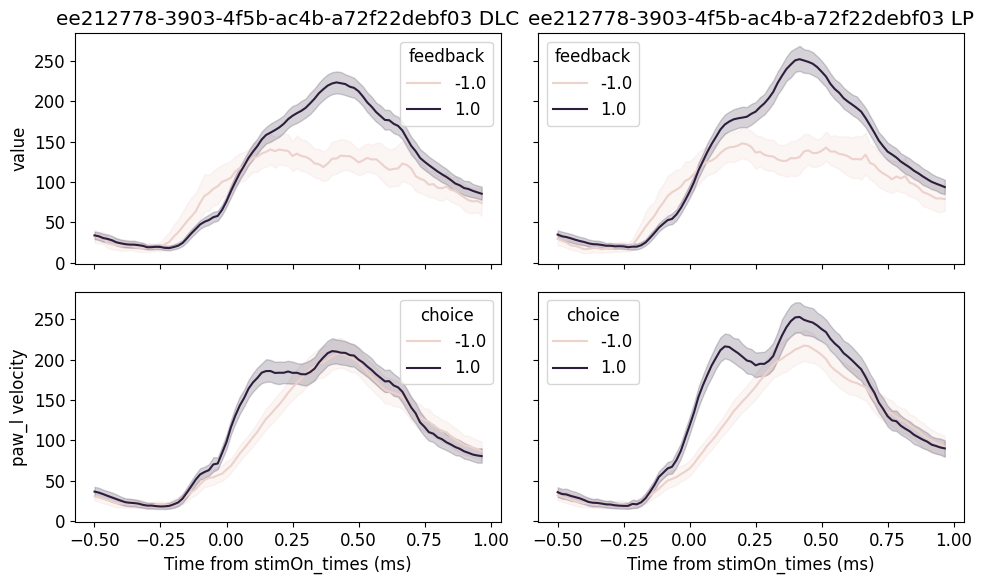

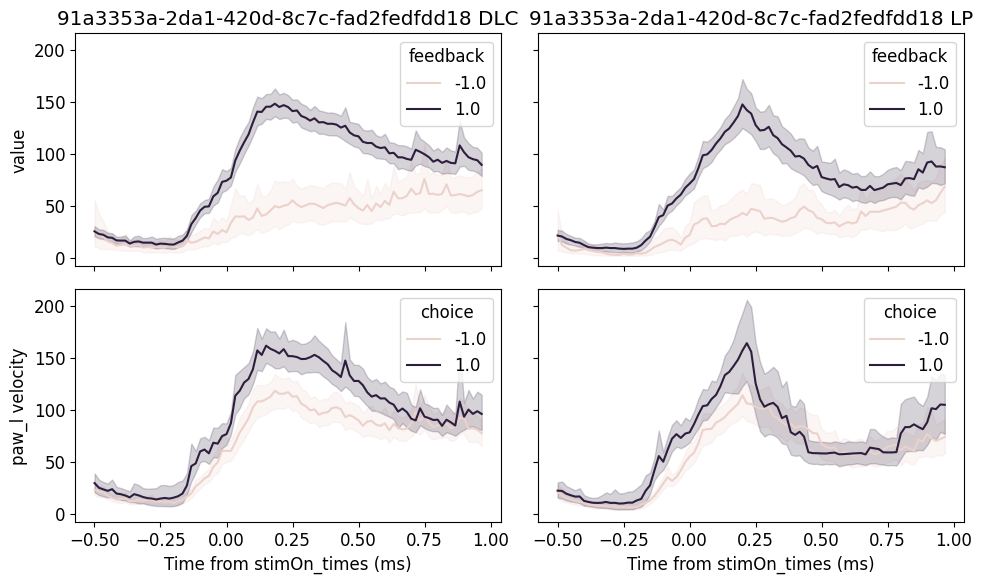

In [36]:
video_type = 'left'
t_init = 0.5
t_end = 1
event = 'stimOn_times'
keypoint = 'paw_l'
ephys = True
split=False

save_path = prefix + '/representation_learning_variability/Video and wheel/Video QC/Figures/Paws/'
files = os.listdir(save_path)

eids = final_qc['eid'].unique()
for e, session in enumerate(eids):
        filename = str(session + '_paw_psth.png')
        if filename not in files:

            session_trials = one.load_object(session, obj='trials', namespace='ibl')
            session_trials = session_trials.to_df() 

            speeds_dlc = keypoint_speed_one_camera(one, session, ephys, video_type, keypoint, split, False)
            speeds_lp = keypoint_speed_one_camera(one, session, ephys, video_type, keypoint, split, True)

            dlc = timeseries_PSTH(speeds_dlc['left'][0][1:], speeds_dlc['left'][1], session_trials, event, t_init, t_end, subtract_baseline=False)
            lp = timeseries_PSTH(speeds_lp['left'][0][1:], speeds_lp['left'][1], session_trials, event, t_init, t_end, subtract_baseline=False)

            # Plot and save
            fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=[10, 6])
            plt.rc('font', size=12)

            algos = ['DLC', 'LP']
            data = [dlc, lp]

            for a, algo in enumerate(data):
                this_data = data[a]
                this_data = this_data.loc[this_data['choice']!=0]
                # this_data['smooth_value'] = this_data['value'].rolling(3, min_periods=1).mean()
                # this_data = this_data.loc[this_data['choice'].isin([1., -1.])]

                sns.lineplot(x='variable', y='value', hue='feedback', data=this_data, ax = ax[0,a])
                sns.lineplot(x='variable', y='value', hue='choice', data=this_data, ax = ax[1,a])

                ax[1, a].set_xlabel('Time from ' + event + ' (ms)')
                ax[1, a].set_ylabel(str(keypoint) + ' velocity')
                ax[1, a].set_ylabel(str(keypoint) + ' velocity')

                ax[0, a].set_title(session + str(' ') + algos[a])

            plt.tight_layout()

            # Save the plot as a PNG file
            plt.savefig(str(save_path + session + '_paw_psth.png'), format='png')
            # Display the plot
            # plt.show()  

